In [1]:
import os
import torch
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.insert(0, './src')
%matplotlib inline
from metrics import NDCG_binary_at_k_batch, Recall_at_k_batch
from models import MultiVAE, MultiDAE, Multi_our_VAE, MultiHoffmanVAE, Multi_ourHoffman_VAE
from training import train_met_model
from args import get_args
from kernels import HMC_our, Reverse_kernel
import numpy as np
import pandas as pd

sys.path.insert(0, '../')
from target import GMM_target2

import pdb

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:
args = dotdict({})

args.device = 'cpu'
L = 2
z_dim = 32
K = 64

print_info_ = 100

args.train_batch_size = 250
args.n_epoches = 500

In [3]:
# 'Encoder' - simple matrix
class Encoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Encoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.L, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=self.z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Decoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.z_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.L)
#         self.sigma = nn.Linear(in_features=K, out_features=self.L)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2) #, nn.functional.softplus(self.sigma(h3))

In [4]:
# GMM with arbitraty many components
comp_1 = 1
comp_2 = 0.7
args['num_gauss'] = 8
args['p_gaussians'] = [torch.tensor(1. / args['num_gauss'], device=args.device, dtype=args.torchType)] * args['num_gauss']
args['locs'] = [torch.tensor([0., comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([0., -comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, comp_2], dtype=args.torchType, device=args.device)]  # list of locations for each of these gaussians
args['covs'] = [0.01 * torch.eye(2, dtype=args.torchType, device=args.device)] * args['num_gauss']   # list of covariance matrices for each of these

target = GMM_target2(args)
data = target.get_samples(1000)

In [5]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.train_batch_size, shuffle=True)

## VAE

  0%|          | 0/500 [00:00<?, ?it/s]

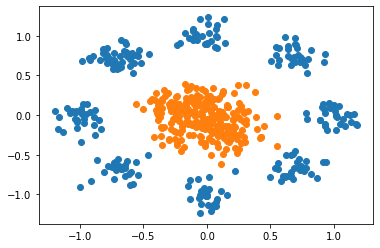

  1%|          | 4/500 [00:00<01:48,  4.58it/s]

elbo: -1.2279917001724243


 20%|█▉        | 99/500 [00:03<00:17, 23.43it/s]

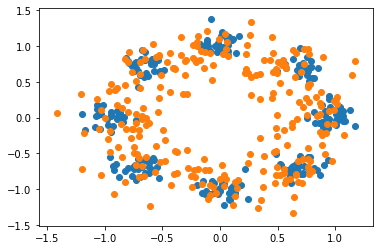

 21%|██        | 105/500 [00:04<00:21, 18.32it/s]

elbo: -1.0131986141204834


 40%|███▉      | 198/500 [00:08<00:15, 19.17it/s]

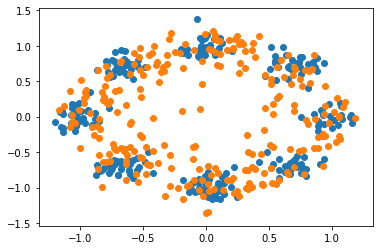

 41%|████▏     | 207/500 [00:09<00:17, 16.52it/s]

elbo: -1.008252501487732


 60%|█████▉    | 298/500 [00:11<00:05, 38.48it/s]

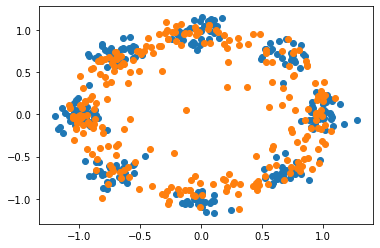

 61%|██████    | 303/500 [00:11<00:08, 22.49it/s]

elbo: -1.0045262575149536


 80%|███████▉  | 399/500 [00:15<00:05, 19.59it/s]

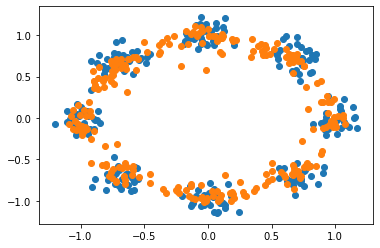

 81%|████████  | 405/500 [00:15<00:05, 18.21it/s]

elbo: -1.005211591720581


100%|██████████| 500/500 [00:19<00:00, 26.07it/s]


In [6]:
enc = Encoder_vae(L=L, z_dim=z_dim).to(args.device)
dec = Decoder_vae(L=L, z_dim=z_dim).to(args.device)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                scale=torch.tensor(1., device=args.device))
args.std_normal = std_normal

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-3)
for ep in tqdm(range(args.n_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()   
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick
        
        mu_recovered = dec(z)
        log_likelihood = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean()
    
#         sum_log_sigma = torch.sum(torch.log(sigma), 1)
#         log_prior = std_normal.log_prob(z).sum(1)
#         log_q = std_normal.log_prob((z - mu) / sigma).sum(1) - sum_log_sigma
#         elbo = torch.mean(log_likelihood + log_prior - log_q)

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
#     scheduler.step(elbo)
    if ep % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()
        print('elbo:', elbo.cpu().detach().item())

## MetVAE

In [15]:
args.torchType = torch.float32

args.annealing = False
args.learnable_reverse = True
args.learntransitions = True

## Transition parameters (only for our vae)
if args.learntransitions:
    args.gamma = 0.1
    # args.alpha = 0.5
else:
    args.gamma = 0.005  # Stepsize
args.alpha = 0.9  #0.5  # For partial momentum refresh
args.use_barker = True
args.use_partialref = True

args.K = 3
args.N = 1
args.z_dim = z_dim

args.lrenc = 1e-3
args.lrdec = 1e-3

args.l2_coeff = 0.

if args.annealing:
    args.total_anneal_steps = 46000
else:
    args.total_anneal_steps = 0
    args.anneal_cap = 1.

In [16]:
class Target(nn.Module):
    def __init__(self, dec, device='cpu'):
        super(Target, self).__init__()
        self.decoder = dec
        self.prior = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                                scale=torch.tensor(1., device=device, dtype=torch.float32))

    def get_logdensity(self, x, z, prior=None, args=None, prior_flow=None):
        """
        The method returns target logdensity
        Input:
        x - datapoint
        z - latent vaiable
        Output:
        log_density - log p(x, z)
        """
        mu_recovered = self.decoder(z)
        log_density = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1) + self.prior.log_prob(z).sum(1)
        return log_density

In [17]:
class Multi_our_VAE(nn.Module):
    def __init__(self, encoder, decoder, args=None):
        super(Multi_our_VAE, self).__init__()

        ## Define encoder
        self.encoder = encoder(L=2, z_dim=32)
        print(self.encoder)

        ## Define target(decoder)
        decoder = decoder(L=2, z_dim=32)
        print(decoder)
        self.target = Target(dec=decoder, device=args.device)

        ## Define transitions
        self.K = args.K
        self.transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

        ## Define reverse kernel (if it is needed)
        self.learnable_reverse = args.learnable_reverse
        if args.learnable_reverse:
            self.reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)

        self.dropout = nn.Dropout()

        device_zero = torch.tensor(0., dtype=torch.float32, device=args.device)
        device_one = torch.tensor(1., dtype=torch.float32, device=args.device)
        self.std_normal = torch.distributions.Normal(loc=device_zero, scale=device_one)
        self.torch_log_2 = torch.tensor(np.log(2), device=args.device, dtype=args.torchType)

    def forward(self, x):
        mu, std = self.encoder(x)
        sum_log_sigma = torch.log(std).sum(1)
        sum_log_alpha = torch.zeros_like(mu[:, 0])
        sum_log_jacobian = torch.zeros_like(mu[:, 0])

        u = self.std_normal.sample(mu.shape)
        z = mu + u * std

        p_old = self.std_normal.sample(z.shape)
        p_ = p_old.detach()

        if self.learnable_reverse:
            all_directions = torch.tensor([], device=x.device)
        else:
            all_directions = None

        for i in range(self.K):
            cond_vector = self.std_normal.sample(p_.shape)
            z, p_, log_jac, current_log_alphas, directions, _ = self.transitions[i].make_transition(q_old=z, x=x,
                                                                                                    p_old=p_,
                                                                                                    k=cond_vector,
                                                                                                    target_distr=self.target)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac
            if self.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)

        ## logdensity of Variational family
        log_q = self.std_normal.log_prob(u).sum(1) + self.std_normal.log_prob(p_old).sum(
            1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha

        ## logdensity of prior
        log_priors = self.std_normal.log_prob(z).sum(1) + self.std_normal.log_prob(p_).sum(1)

        ## logits
        logits = self.target.decoder(z)

        ## logdensity of reverse (if needed)
        if self.learnable_reverse:
            log_r = self.reverse_kernel(z_fin=z.detach(), h=mu.detach(), a=all_directions)
        else:
            log_r = -self.K * self.torch_log_2

        return logits, log_q, log_priors, log_r, sum_log_alpha, all_directions


In [18]:
model = Multi_our_VAE(encoder=Encoder_vae, decoder=Decoder_vae, args=args)

Encoder_vae(
  (h1): Linear(in_features=2, out_features=64, bias=True)
  (h2): Linear(in_features=64, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=32, bias=True)
  (sigma): Linear(in_features=64, out_features=32, bias=True)
)
Decoder_vae(
  (h1): Linear(in_features=32, out_features=64, bias=True)
  (h2): Linear(in_features=64, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=2, bias=True)
)


  0%|          | 0/500 [00:00<?, ?it/s]

39.907135
k = 0
0: 0.528 and for +1: 0.472
autoreg: 0.8999999761581421
stepsize 0.010225307196378708
----------------------------------------------------------------------------------------------------
k = 1
0: 0.5 and for +1: 0.5
autoreg: 0.8999999761581421
stepsize 0.011540467850863934
----------------------------------------------------------------------------------------------------
k = 2
0: 0.556 and for +1: 0.444
autoreg: 0.8999999761581421
stepsize 0.009503324516117573
----------------------------------------------------------------------------------------------------


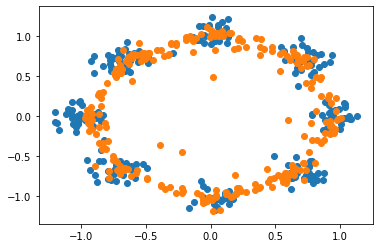

  0%|          | 1/500 [00:00<04:07,  2.02it/s]

elbo: 38.03310012817383


 20%|██        | 100/500 [00:27<01:37,  4.11it/s]

52.08692
k = 0
0: 0.512 and for +1: 0.488
autoreg: 0.8999999761581421
stepsize 0.006812961772084236
----------------------------------------------------------------------------------------------------
k = 1
0: 0.548 and for +1: 0.452
autoreg: 0.8999999761581421
stepsize 0.007919913157820702
----------------------------------------------------------------------------------------------------
k = 2
0: 0.488 and for +1: 0.512
autoreg: 0.8999999761581421
stepsize 0.006317066494375467
----------------------------------------------------------------------------------------------------


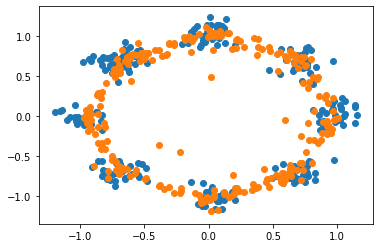

 20%|██        | 102/500 [00:28<01:47,  3.72it/s]

elbo: 54.893951416015625


 40%|████      | 200/500 [00:47<01:07,  4.42it/s]

86.69853
k = 0
0: 0.56 and for +1: 0.44
autoreg: 0.8999999761581421
stepsize 0.004575625061988831
----------------------------------------------------------------------------------------------------
k = 1
0: 0.496 and for +1: 0.504
autoreg: 0.8999999761581421
stepsize 0.0053065624088048935
----------------------------------------------------------------------------------------------------
k = 2
0: 0.468 and for +1: 0.532
autoreg: 0.8999999761581421
stepsize 0.004229292273521423
----------------------------------------------------------------------------------------------------


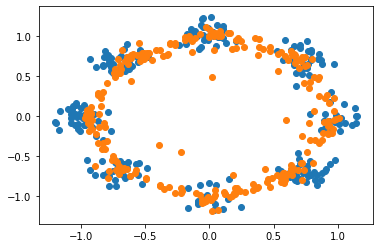

 40%|████      | 201/500 [00:47<01:33,  3.19it/s]

elbo: 79.22689819335938


 60%|██████    | 300/500 [01:11<00:46,  4.30it/s]

124.09369
k = 0
0: 0.52 and for +1: 0.48
autoreg: 0.8999999761581421
stepsize 0.0031912834383547306
----------------------------------------------------------------------------------------------------
k = 1
0: 0.516 and for +1: 0.484
autoreg: 0.8999999761581421
stepsize 0.0036411085166037083
----------------------------------------------------------------------------------------------------
k = 2
0: 0.52 and for +1: 0.48
autoreg: 0.8999999761581421
stepsize 0.00286052655428648
----------------------------------------------------------------------------------------------------


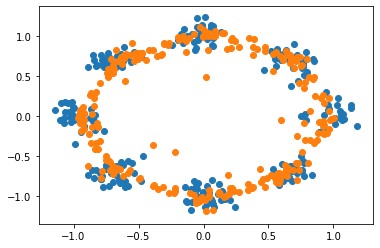

 60%|██████    | 301/500 [01:11<00:55,  3.58it/s]

elbo: 124.65583038330078


 80%|████████  | 400/500 [01:34<00:17,  5.75it/s]

135.91855
k = 0
0: 0.48 and for +1: 0.52
autoreg: 0.8999999761581421
stepsize 0.002029704861342907
----------------------------------------------------------------------------------------------------
k = 1
0: 0.488 and for +1: 0.512
autoreg: 0.8999999761581421
stepsize 0.002363438019528985
----------------------------------------------------------------------------------------------------
k = 2
0: 0.48 and for +1: 0.52
autoreg: 0.8999999761581421
stepsize 0.001820817356929183
----------------------------------------------------------------------------------------------------


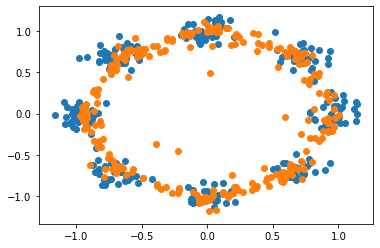

 80%|████████  | 402/500 [01:34<00:21,  4.58it/s]

elbo: 133.44448852539062


100%|██████████| 500/500 [01:54<00:00,  4.38it/s]


In [20]:
update_count = 0.0

if args.lrenc is None:
    lrenc = args.lrdec
else:
    lrenc = args.lrenc

if not args.learntransitions:
    for p in model.transitions.parameters():
        p.requires_grad_(False)
else:
    for k in range(len(model.transitions)):
        model.transitions[k].alpha_logit.requires_grad_(False)

if args.learnable_reverse:
    optimizer = torch.optim.Adam([
        {'params': model.target.decoder.parameters(), 'lr': args.lrdec},
        {'params': model.encoder.parameters()},
        {'params': model.transitions.parameters()},
        {'params': model.reverse_kernel.parameters()},
    ],
        lr=lrenc, weight_decay=args.l2_coeff)
else:
    optimizer = torch.optim.Adam([
        {'params': model.target.decoder.parameters(), 'lr': args.lrdec},
        {'params': model.encoder.parameters()},
        {'params': model.transitions.parameters()},
    ],
        lr=lrenc, weight_decay=args.l2_coeff)

for epoch in tqdm(range(args.n_epoches)):
    plt.close()
    for bnum, batch_train in enumerate(dataloader):

        if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 1. * update_count / args.total_anneal_steps)
        else:
            anneal = args.anneal_cap

        logits, log_q, log_priors, log_r, sum_log_alpha, directions = model(batch_train)

        # loglikelihood part
        log_softmax_var = nn.LogSoftmax(dim=-1)(logits)
        log_p = torch.mean(torch.sum(log_softmax_var * batch_train, dim=1))

        # compute objective
        elbo_full = log_p + (log_priors + log_r - log_q) * anneal
        grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
        (-grad_elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
        
#         pdb.set_trace()
        if (bnum % 200 == 0) and (epoch % print_info_ == 0):
            print(elbo_full.cpu().detach().mean().numpy())
            for k in range(args.K):
                print('k =', k)
                print('0: {} and for +1: {}'.format((directions[:, k] == 0.).to(float).mean(), (directions[:, k] == 1.).to(float).mean()))
                print('autoreg:', torch.sigmoid(model.transitions[k].alpha_logit.detach()).item())
                print('stepsize', torch.exp(model.transitions[k].gamma.detach()).item())
                print('-' * 100)

        update_count += 1
    if np.isnan(elbo_full.cpu().detach().mean().numpy()):
        break
    if epoch % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()
        print('elbo:', elbo_full.cpu().detach().mean().item())